In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Load data:

- This data is grouped for "World" region. 
- I focuse on 2021 data for clustering and heatmap.

In [3]:
food_df = pd.read_parquet('../data/FAOSTAT/clean_data/all_tables_processed/food_emissions/merged_food_prod_transport_emissions_world_v3.parquet')
food_df = food_df[food_df['Year'] == 2021]

## Select columns for clustering and heatmap:

There are a lot of crops and livestock specific columns in the data with 0 values.

In [4]:
cols_for_heatmap = [ #Cannot use crops or livestock specific columns for this
 'production_TOTAL_(emissions_CO2eq)_(kt)',
 'Food_supply_(kcal/capita/day)_kcal/cap/d',
 'Food_supply_quantity_(g/capita/day)_g/cap/d',
 'Food_supply_quantity_(tonnes)_t',
 'Protein_supply_quantity_(g/capita/day)_g/cap/d',
 'Production_t_y',
 'Export_Quantity_t_y',
 'Export_Value_1000_USD',
 'Gross_Production_Value_(current_thousand_US$)_1000_USD',
 'food_miles',
 'transport_TOTAL_(emissions_CO2eq)_(kt)',
]

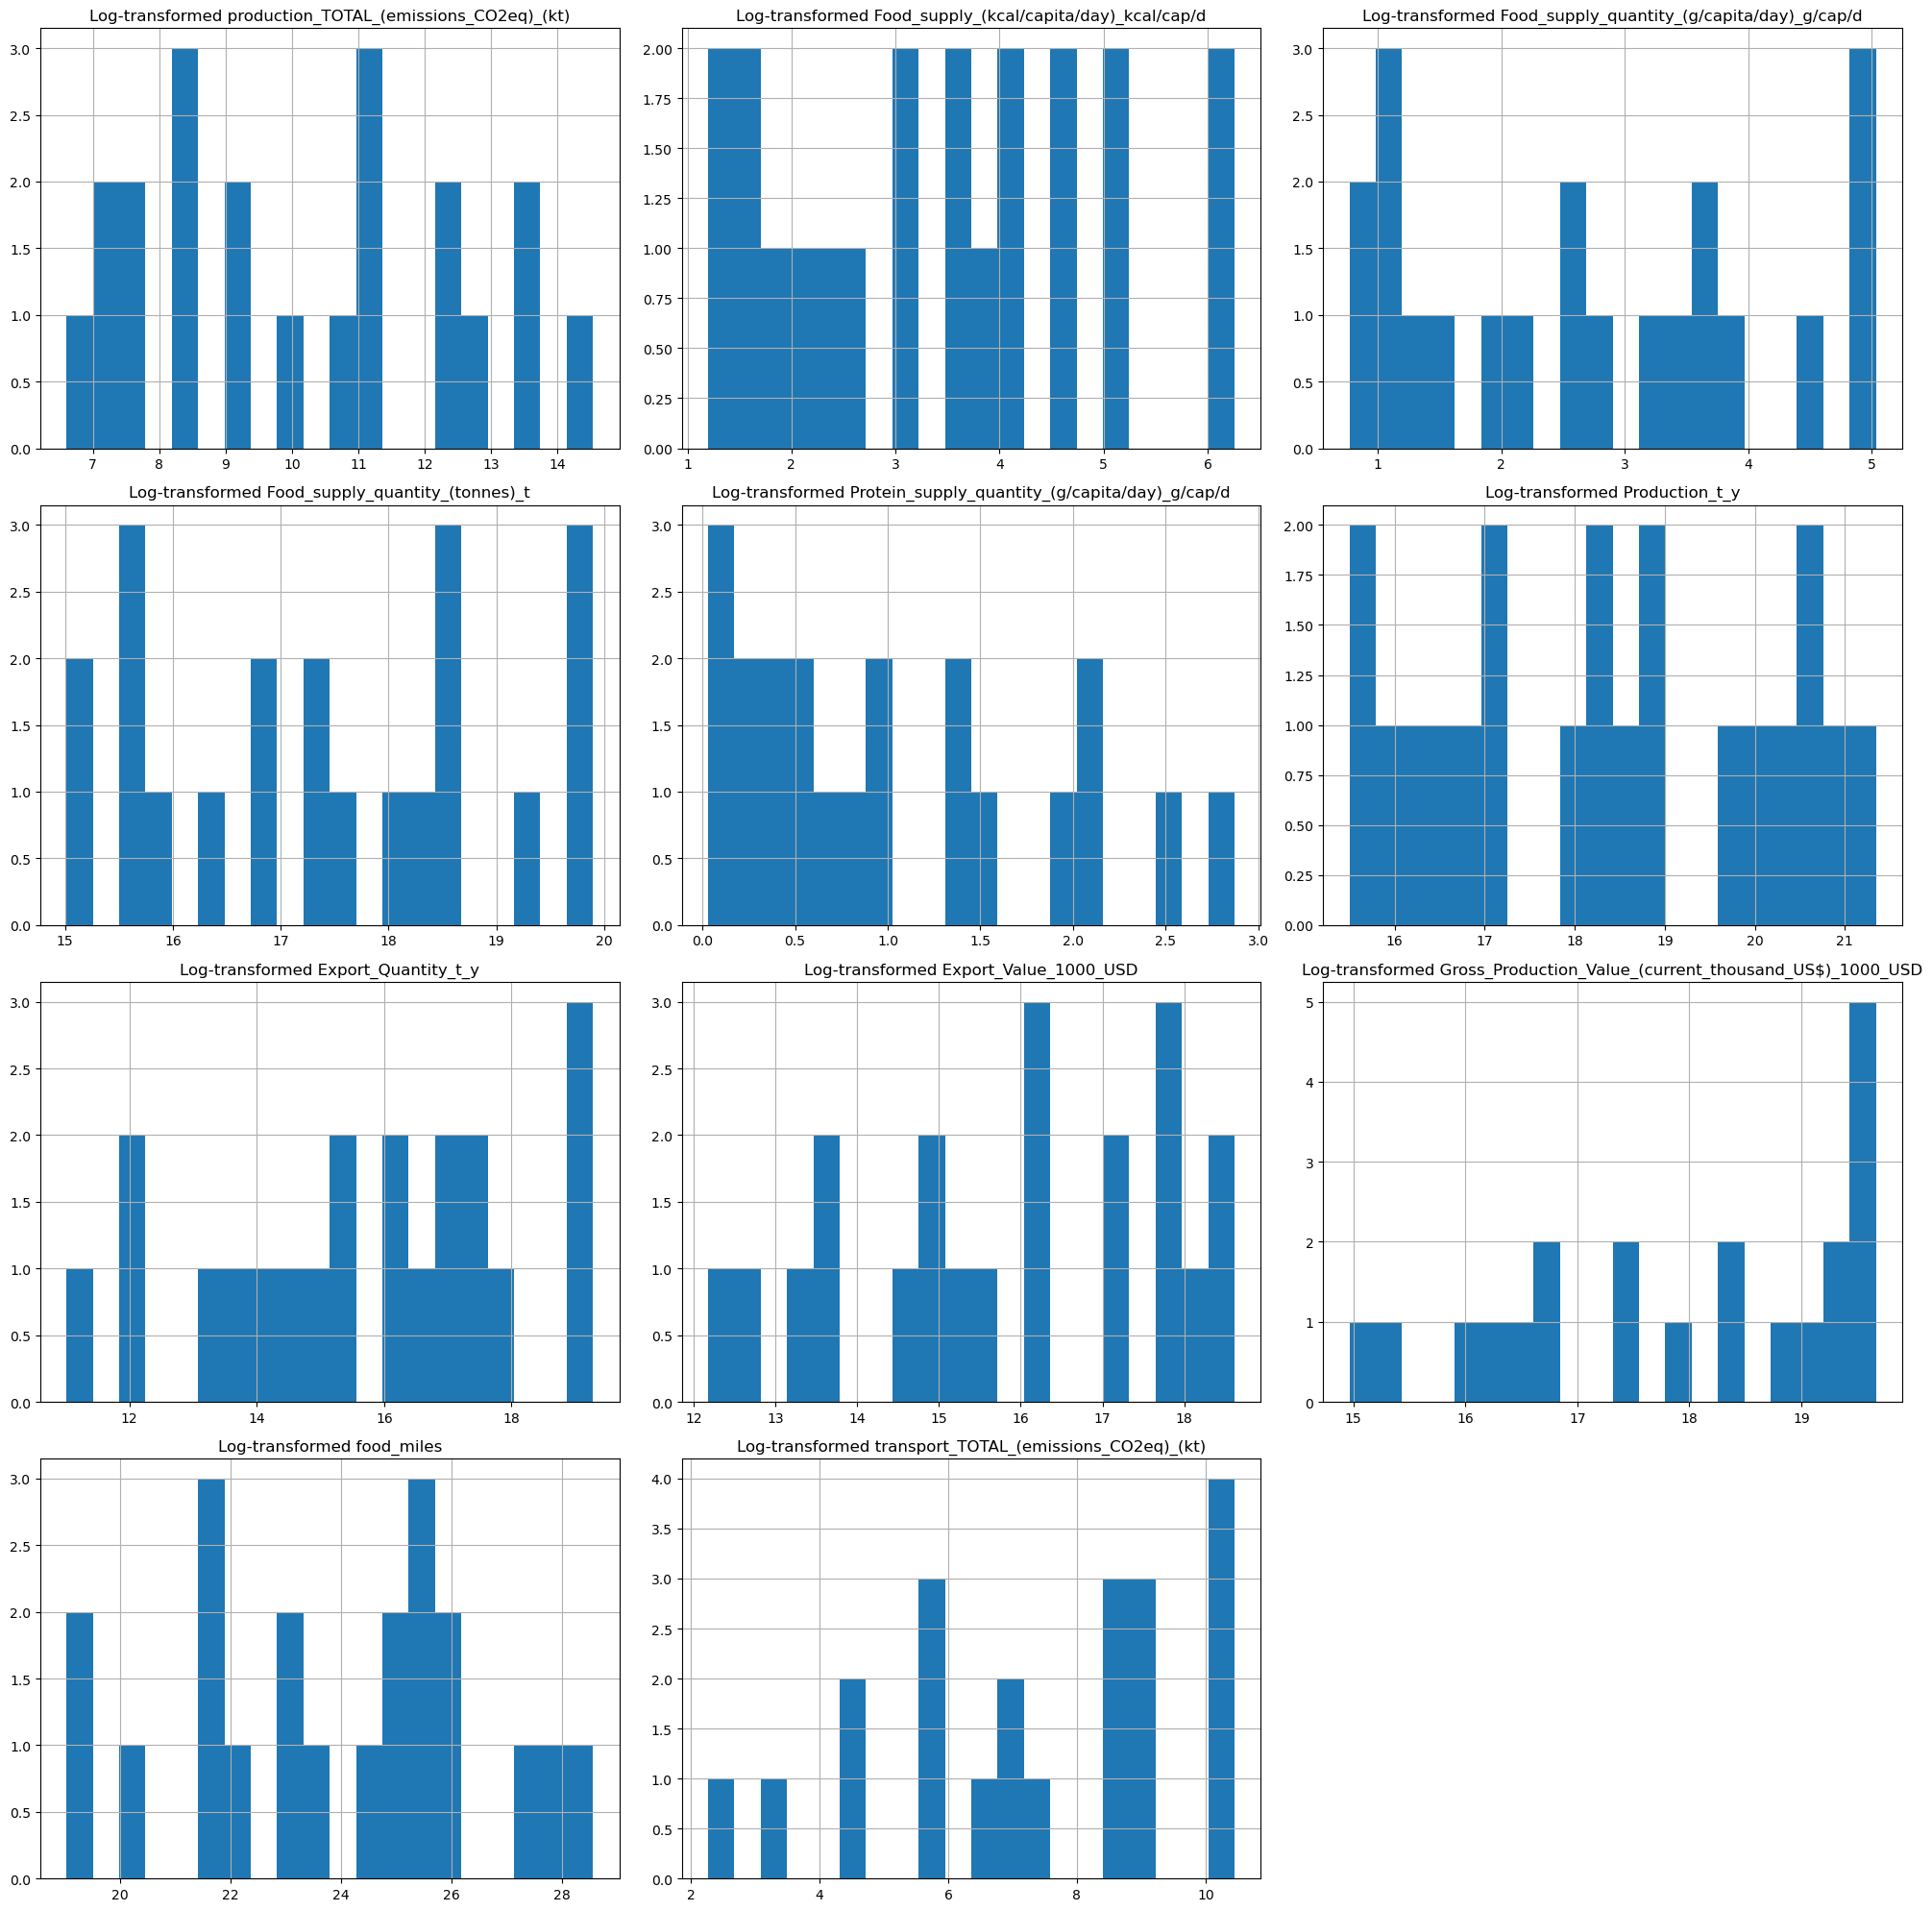

In [5]:
# cols_for_heatmap = food_df.select_dtypes(include=['number']).columns.tolist()
num_cols = 3
num_rows = (len(cols_for_heatmap) + num_cols - 1) // num_cols  # Calculate number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))

for idx, col in enumerate(cols_for_heatmap):
    row, col_pos = divmod(idx, num_cols)
    ax = axes[row, col_pos]
    
    # Apply a logarithmic transformation to the data, adding 1 to avoid log(0)
    transformed_data = np.log1p(food_df[col])
    
    # Plot the histogram of the transformed data
    transformed_data.hist(ax=ax, bins=20)
    ax.set_title(f'Log-transformed {col}')

# Remove empty subplots
for i in range(len(cols_for_heatmap), num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


## Scale data for better visualization and plot Clustermap heatmap:

In [6]:
cat_columns = ['Item', 'crops_or_livestock']
heat_df = food_df[cat_columns+cols_for_heatmap].copy()
heat_df.head()

,Item,crops_or_livestock,production_TOTAL_(emissions_CO2eq)_(kt),Food_supply_(kcal/capita/day)_kcal/cap/d,Food_supply_quantity_(g/capita/day)_g/cap/d,Food_supply_quantity_(tonnes)_t,Protein_supply_quantity_(g/capita/day)_g/cap/d,Production_t_y,Export_Quantity_t_y,Export_Value_1000_USD,Gross_Production_Value_(current_thousand_US$)_1000_USD,food_miles,transport_TOTAL_(emissions_CO2eq)_(kt)
735,Wheat,crops,58784.3935,509.62,148.91,4.271962e+08,16.66,7.727794e+08,2.209968e+08,62529075.0,225915953.0,8.396618e+11,24714.342400
736,Rice,crops,741922.0861,521.15,148.51,4.259867e+08,10.63,7.890453e+08,5.325774e+07,27230220.0,347245645.0,1.723844e+11,9230.931235
737,Barley,crops,9248.0230,6.64,2.05,5.859414e+06,0.21,1.451331e+08,4.359644e+07,10479766.0,34716056.0,2.250382e+11,4951.651438
738,Maize (corn),crops,69809.7755,152.72,43.85,1.257719e+08,3.10,1.220605e+09,2.025908e+08,55198927.0,327301198.0,1.154579e+12,30232.816452
739,Rye,crops,735.7460,3.80,1.16,3.315798e+06,0.13,1.311956e+07,2.425862e+06,579707.0,3153292.0,2.943735e+09,346.652190


### With MinMaxScaler:

In [7]:
df = heat_df.copy()

# Apply standardization to scale the data
scaler = MinMaxScaler()
df[cols_for_heatmap] = scaler.fit_transform(df[cols_for_heatmap])

# Set 'Item' as index
df.set_index('Item', inplace=True)

# Transpose the DataFrame for the heatmap
df_transposed = df.drop('crops_or_livestock', axis=1).transpose()

# Create a color palette for the 'crops_or_livestock' column
lut = {'crops': 'blue', 'livestock': 'orange'}
column_colors = df['crops_or_livestock'].map(lut)

Default clustermap parameters are:
- Linkage method: Average linkage (UPGMA)
- Distance metric: Euclidean distance

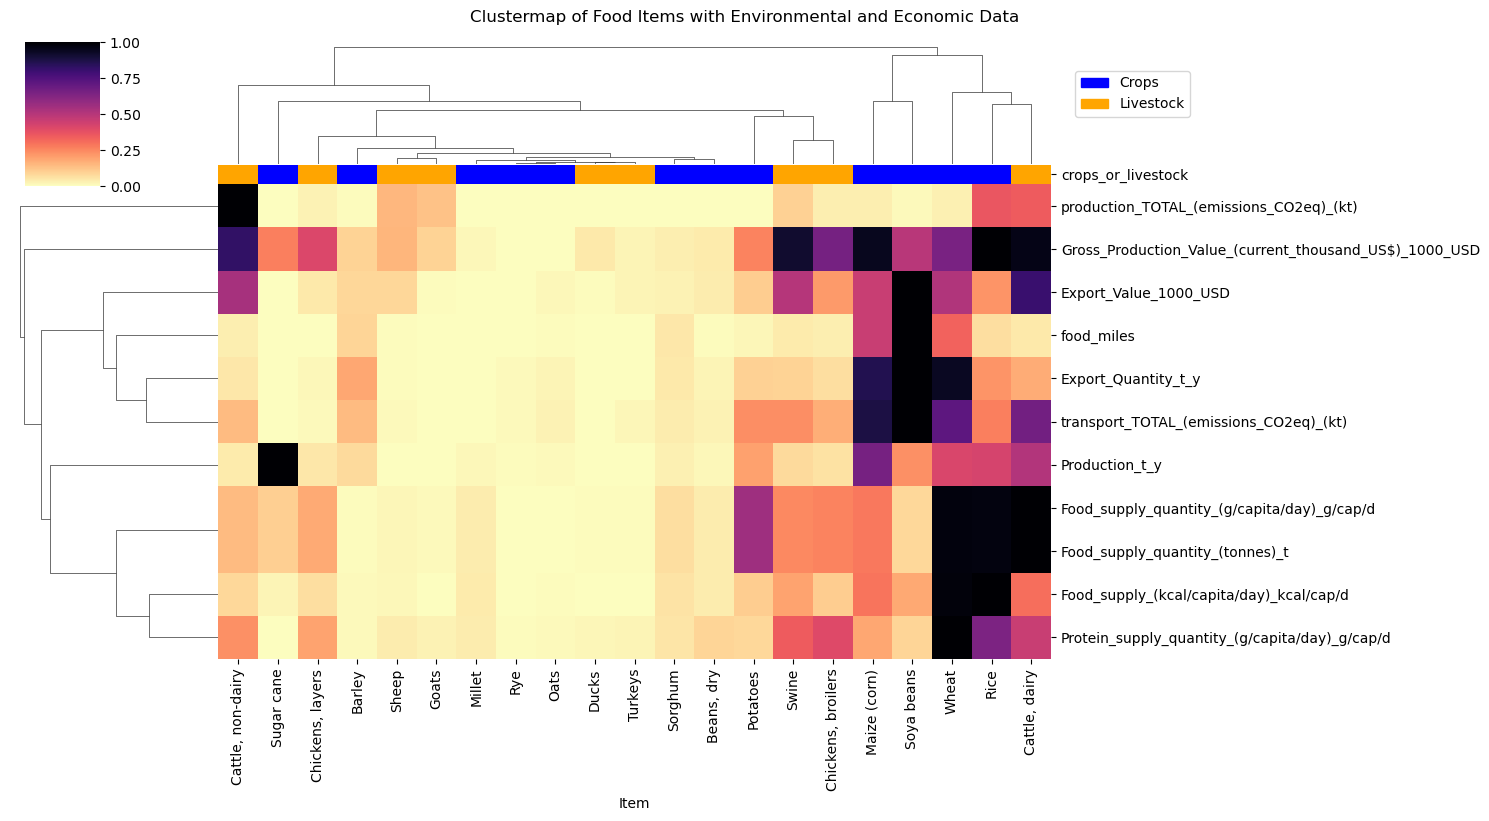

In [8]:
# Create the clustermap
g = sns.clustermap(df_transposed, cmap="magma_r", col_colors=column_colors, figsize=(15, 8))

# Add title
plt.suptitle("Clustermap of Food Items with Environmental and Economic Data", y=1.02)

# Create legend patches
legend_patches = [mpatches.Patch(color='blue', label='Crops'), mpatches.Patch(color='orange', label='Livestock')]

# Add legend to the plot
plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(14, 0.8), borderaxespad=0.)

plt.savefig('../plots/food_items_hierch_clustering_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

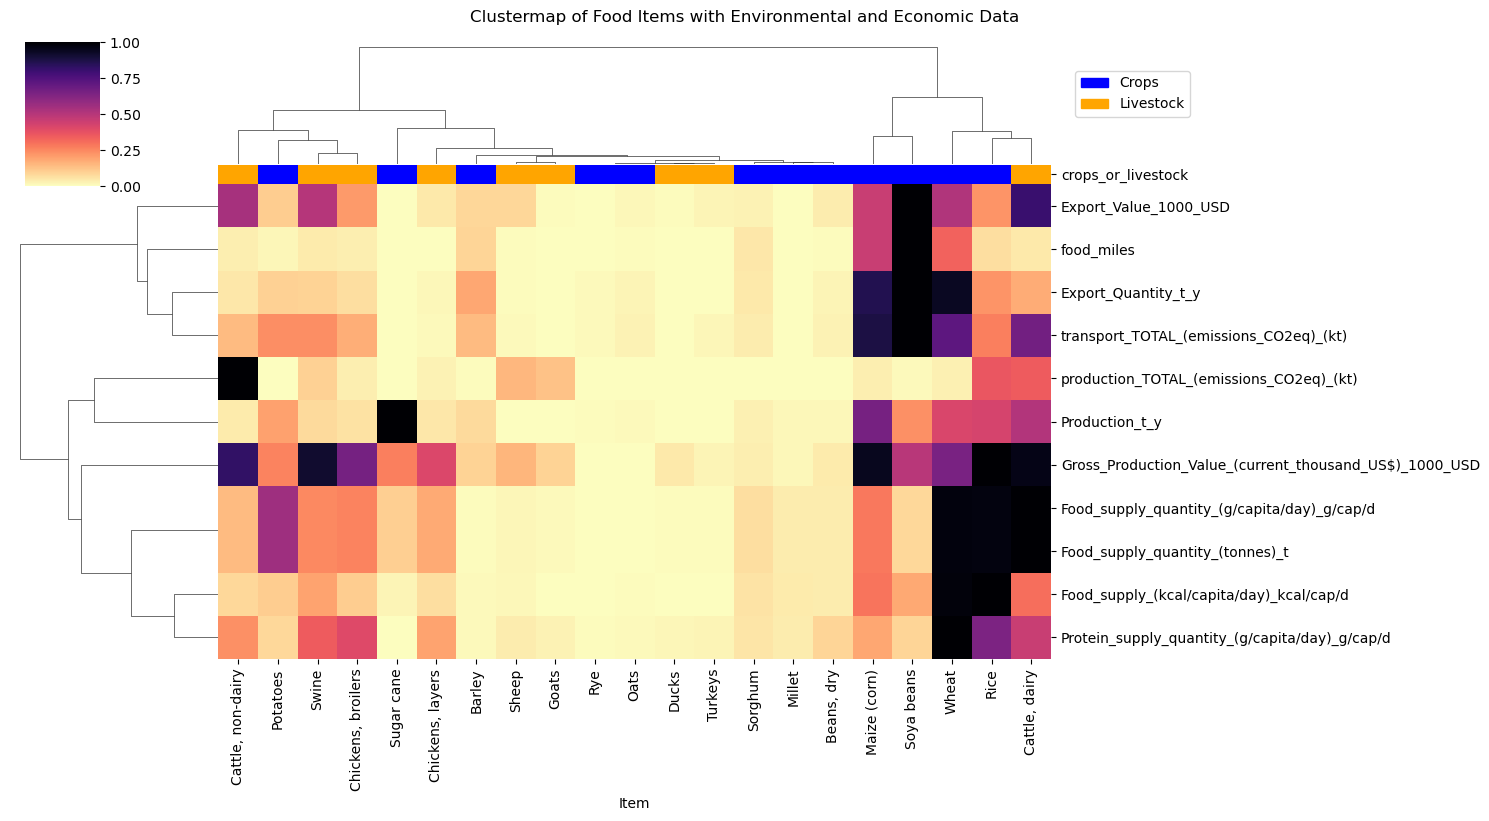

In [9]:
# Create the clustermap
g = sns.clustermap(df_transposed, cmap="magma_r", col_colors=column_colors, figsize=(15, 8), method='ward')

# Add title
plt.suptitle("Clustermap of Food Items with Environmental and Economic Data", y=1.02)

# Create legend patches
legend_patches = [mpatches.Patch(color='blue', label='Crops'), mpatches.Patch(color='orange', label='Livestock')]

# Add legend to the plot
plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(14, 0.8), borderaxespad=0.)

plt.savefig('../plots/food_items_hierch_clustering_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

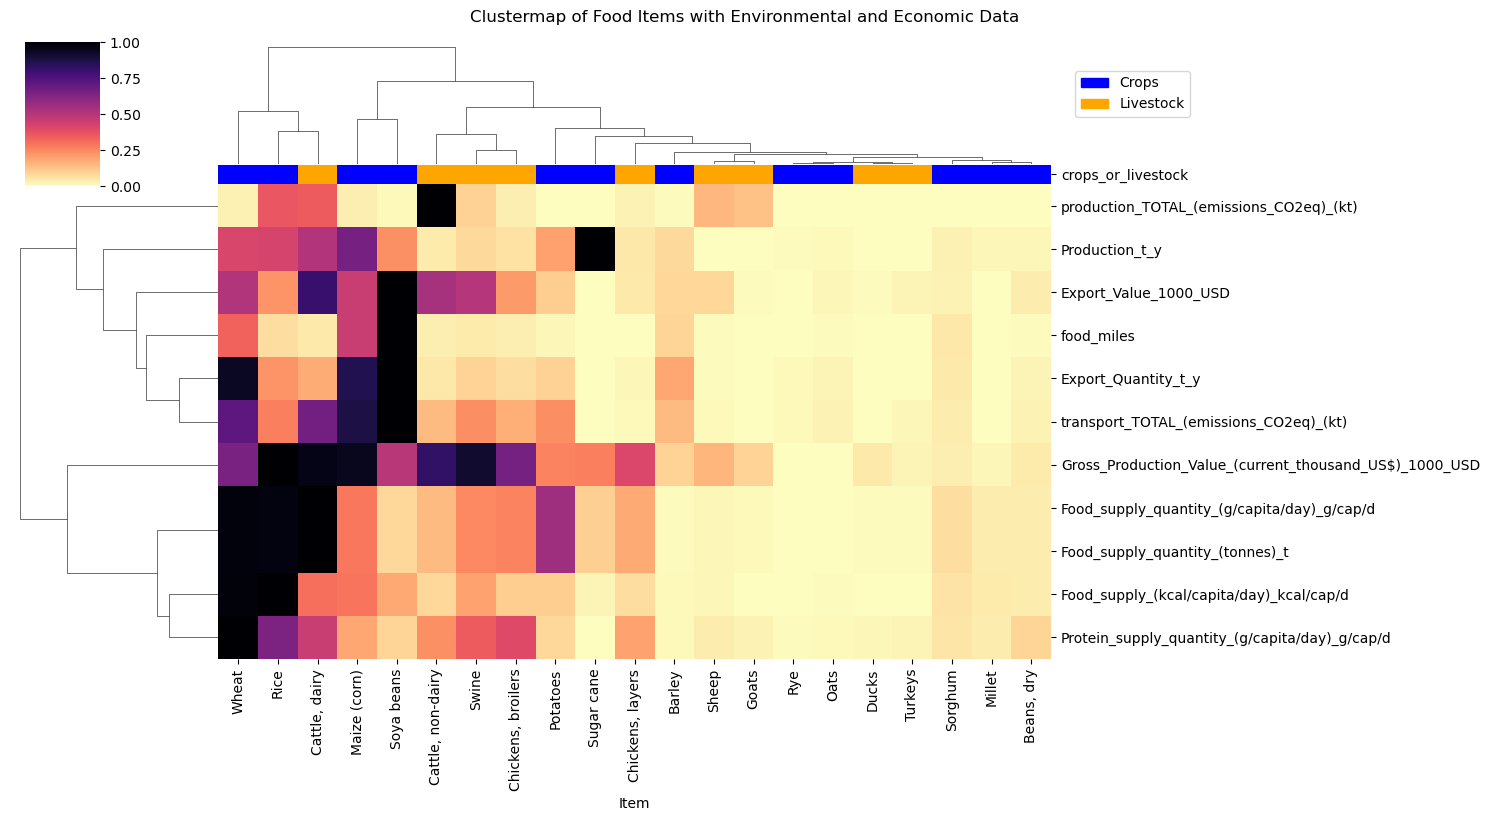

In [10]:
# Create the clustermap
g = sns.clustermap(df_transposed, cmap="magma_r", col_colors=column_colors, figsize=(15, 8), method='complete', metric='cityblock')

# Add title
plt.suptitle("Clustermap of Food Items with Environmental and Economic Data", y=1.02)

# Create legend patches
legend_patches = [mpatches.Patch(color='blue', label='Crops'), mpatches.Patch(color='orange', label='Livestock')]

# Add legend to the plot
plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(14, 0.8), borderaxespad=0.)

plt.savefig('../plots/food_items_hierch_clustering_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Specific clustering library to play with dendogram parameters

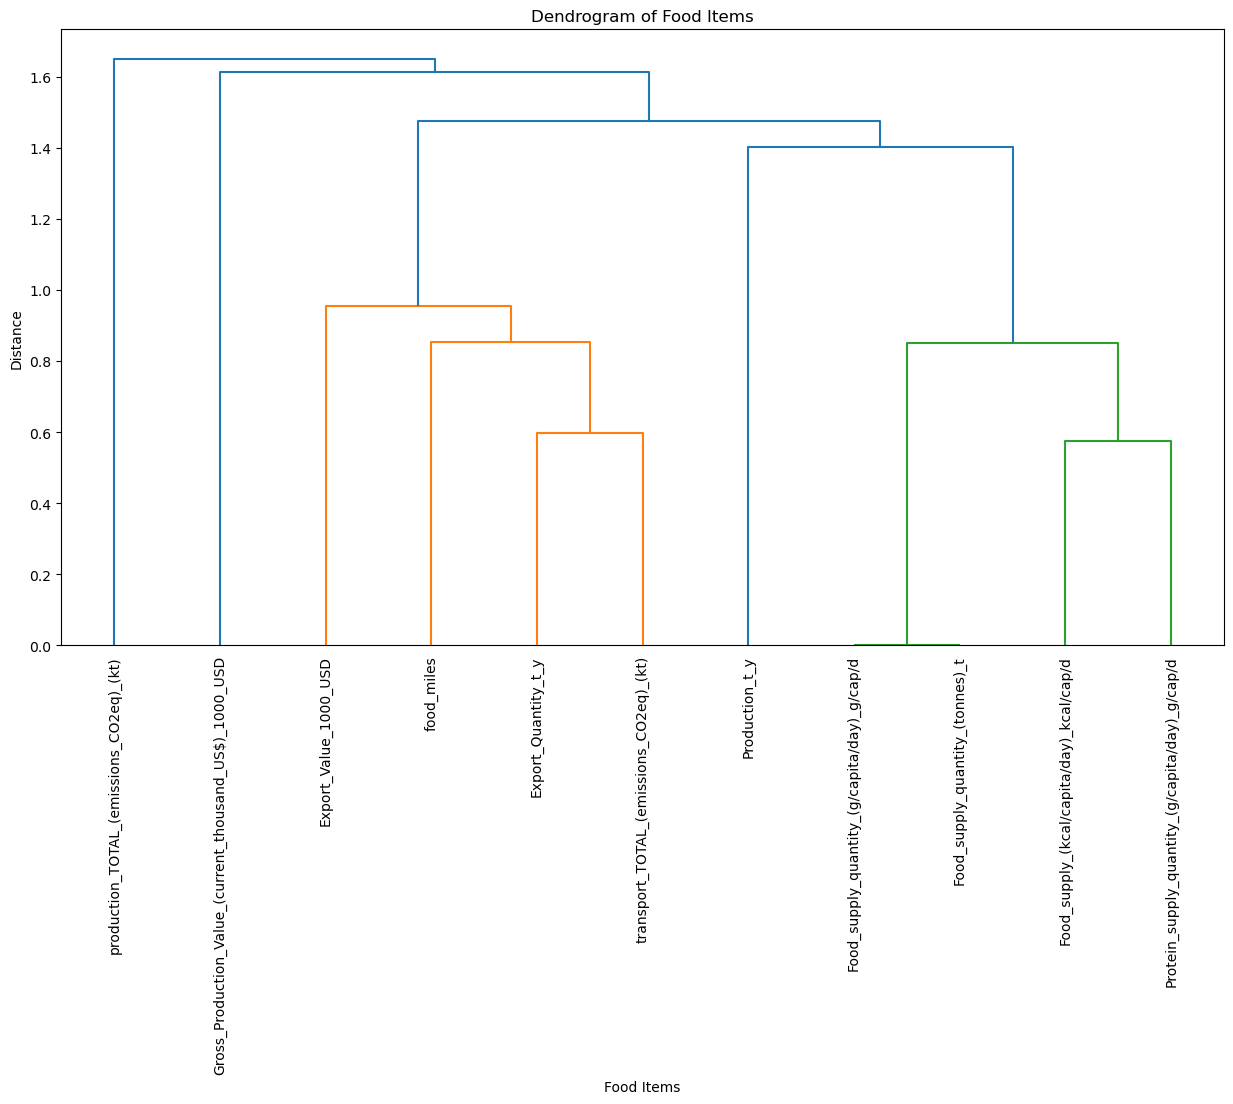

Item                                            Cluster
production_TOTAL_(emissions_CO2eq)_(kt)               7
Food_supply_(kcal/capita/day)_kcal/cap/d              9
Food_supply_quantity_(g/capita/day)_g/cap/d          10
Food_supply_quantity_(tonnes)_t                       8
Protein_supply_quantity_(g/capita/day)_g/cap/d        3


In [13]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage

# CLUSTERING_PARAM: Adjust this dictionary to control clustering behavior
CLUSTERING_PARAM = {
    'n_clusters': None,  # None for dendrogram (to explore), or specify a number for flat clustering
    'distance_threshold': 0,  # Set to 0 to create full dendrogram
    'linkage': 'average',  # Linkage method ('ward', 'complete', 'average', 'single')
    'metric': 'euclidean'  # Distance metric ('euclidean', 'manhattan', 'cosine', etc.)
}

# Standardize and prepare the data (similar to your original code)
df = heat_df.copy()
scaler = MinMaxScaler()
df[cols_for_heatmap] = scaler.fit_transform(df[cols_for_heatmap])
df.set_index('Item', inplace=True)
df_transposed = df.drop('crops_or_livestock', axis=1).transpose()

# Perform hierarchical clustering using sklearn
model = AgglomerativeClustering(
    n_clusters=CLUSTERING_PARAM['n_clusters'],
    metric=CLUSTERING_PARAM['metric'],
    linkage=CLUSTERING_PARAM['linkage'],
    distance_threshold=CLUSTERING_PARAM['distance_threshold']
)

# Fit the model
model = model.fit(df_transposed)

# Generate the linkage matrix for the dendrogram
distance_matrix = pdist(df_transposed, metric=CLUSTERING_PARAM['metric'])
linkage_matrix = linkage(distance_matrix, method=CLUSTERING_PARAM['linkage'])

# Plot dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, labels=df_transposed.index, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrogram of Food Items")
plt.xlabel("Food Items")
plt.ylabel("Distance")
plt.show()

# Optionally, extract the cluster labels
df_transposed['Cluster'] = model.labels_

# Inspect the clusters
print(df_transposed[['Cluster']].head())
